# <b><center>DarkVec: Automatic Analysis of Darknet Trafficwith Word Embeddings</center></b>
## <b><center>Darknet Overview</center></b> 

___
# <b>Table of Content</b> <a id="toc_"></a>
* [<b>Darknet Traffic Overview</b>](#darknet)  
  * [Port Ranking](#portranking)  
  * [Darknet IPs Activity Pattern](#darknetpattern)  
  * [Filter Definition](#darknetfilter)  
  * [Distinct IPs Seen Over 30 Days](#darknetips)  
  * [Last Day of Traffic](#lastday)  
    * [Some Notable GT Activity Patterns](#gtpattern)
    

This notebook provides an overview of the collected darknet traffic. We go through the paper reporting the snippets that generate the statistics and the reported Figures. Namely, this report is related to Section 3 of the paper.

In [1]:
from config import *
from src.callbacks import *
from src.utils import *
from src.knngraph import *

import pandas as pd
import numpy as np
import warnings
import json
from glob import glob

from pandas.core.common import SettingWithCopyWarning
from pandas.errors import DtypeWarning

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=SettingWithCopyWarning)
warnings.filterwarnings("ignore", category=DtypeWarning)

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import fastplot
from cycler import cycler

cc = (cycler('color',['k', 'r', 'b', 'g', 'y', 'm', 'c'])+
      cycler('linestyle',['-', '--', '-.', ':', '-', '--', '-.']))

___
# <b>Darknet Traffic Overview</b> <a name="darknet"></a>

[Back to Index](#toc_)

Load 30 days of raw traffic. From 2021-03-02 to 2021-03-31. This is the full dataset we use in our experiments. 

Although here we load an already slightly preprocessed dataset, we rport in [Appendix 3](A03-darknet-checkpoint.ipynb) the scripts for generating it.

Each row of the dataset is a packet received from the darknet. The dataset columns are:

- `ts`. It is the timestamp of the packet arrival
- `ip`. It is the source IP address sending who sent the packet
- `port`. It is the destination (darknet) port
- `proto`. Used protocol among TCP, UDP, ICMP, GRE, OTH (for others)
- `pp`. `port/proto` pairs used for the language definition
- `class`. Ground truth class of the source IP

In [4]:
%%time
darknet = pd.read_csv(f'{DATASETS}/darknet.csv.gz')
darknet.head()

CPU times: user 1min 27s, sys: 8.27 s, total: 1min 36s
Wall time: 1min 36s


,Unnamed: 0,ts,ip,port,proto,pp,class
0,0,2021-03-02 22:20:25.471441,145.239.33.107,4683,TCP,4683/TCP,unknown
1,1,2021-03-02 22:20:25.636319,89.40.70.51,53,UDP,53/UDP,unknown
2,2,2021-03-02 22:20:25.931752,94.102.51.17,14562,TCP,14562/TCP,unknown
3,3,2021-03-02 22:20:25.943143,80.82.64.130,2300,TCP,2300/TCP,unknown
4,4,2021-03-02 22:20:26.138573,94.102.51.28,14001,TCP,14001/TCP,unknown


In [5]:
print(f'30 days of traffic stats: ')
print(f'{darknet.ip.unique().shape[0]:,} distinct source IPs')
print(f"{darknet.pp.unique().shape[0]:,} destination 'port/protocol' pairs.")
print(f'{darknet.shape[0]:,} received packets')
print(f'Dataset shape: {darknet.shape}')

30 days of traffic stats: 
543,900 distinct source IPs
84,810 destination 'port/protocol' pairs.
63,562,427 received packets
Dataset shape: (63562427, 7)


### <b>Port Ranking</b> <a name="portranking"></a>  
[Back to Index](#toc_)

Then we start investigating the darknet. We focus on the port popularity in terms of received packets. 

In [6]:
# Get the port frequency from 30 days of traffic
top14 = darknet.value_counts('port').reset_index().rename(columns={0:'pkts'})
# Compute the ECDF(packets)
pkts = top14.sort_values('pkts', ascending=False)
pkts.pkts = np.cumsum(pkts.pkts)/np.sum(pkts.pkts)
# Zoom-in: Get the top-14 ports within 30 days
top = top14.sort_values('pkts', ascending=False)
top.pkts = np.cumsum(top.pkts)/np.sum(top14.pkts)
top = top.iloc[:14]

<Figure size 640x480 with 0 Axes>

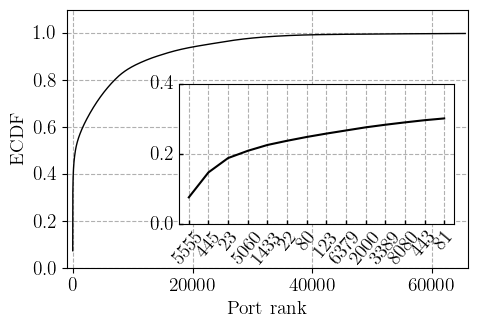

In [7]:
%matplotlib inline
plot = fastplot.plot(None,  None, mode = 'callback', callback = lambda plt: fig1a(plt, pkts, top),
                     style='latex', cycler=cc, figsize=(5, 3.5), fontsize=14)
plot.show()

### <b>Darknet IPs Activity Pattern</b> <a name="darknetpattern"></a>  
[Back to Index](#toc_)

To provide a big picture, trying to visualize some IPs activity pattern may be useful.

We extract a time window shorter than 30 days and downsample the received traffic modulo 3 to make the patterns more evident. Then a scatterplot is generated. Here, each dot is a packet sent by an IP $y$ at the istant $x$.

In [8]:
# Extract a 9 days window to make the IPs patterns more evident
tday_ = darknet[darknet.ts<='2021-3-11 23:28:56.952226'][['ts', 'ip']]
tday = pd.DataFrame(tday_, columns=['ts', 'ip'])
# Manage timestamps and sort them
tday.index = pd.DatetimeIndex(tday.ts)
tday = tday.sort_index()
tday = tday.drop(columns=['ts'])
# Tokenize IPs. From string to integer number
ydict = {v: k for k,v in enumerate(tday.ip.unique())}
tday['tkn'] = tday.ip.apply(lambda x: ydict[x])
# mod3 downsampling for reducing the image weight
resampled_idx = [x for x in range(tday.shape[0]) if x%3 == 0]
tday = tday.iloc[resampled_idx]

<Figure size 640x480 with 0 Axes>

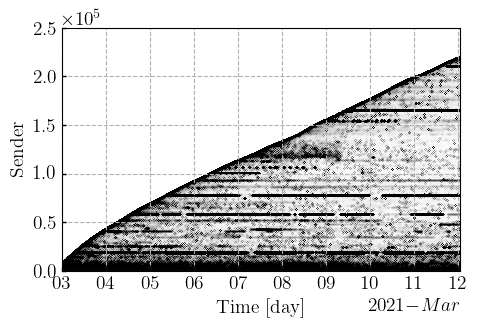

In [9]:
%matplotlib inline
plot = fastplot.plot(None,  None, mode = 'callback', callback = lambda plt: fig1b(plt, tday),
                     style='latex', cycler=cc, figsize=(5, 3.5), fontsize=14)
plot.show()

### <b>Filter Definition</b> <a name="darknetfilter"></a>  
[Back to Index](#toc_)

According to the large amount of packets received in 30 days, a filter is needed. We design our filter with respect to the monthly packets sent by each IP. We evaluate the distribution of this amount and set the filtering threshold to 10. In this way, we keep the IPs sending _at least 10 packets over a month_.

In [10]:
# Count the packets per IP over a month
cdf = darknet.value_counts('ip').reset_index().drop(columns=['ip'])\
             .rename(columns={0:'pkts'}).value_counts('pkts')
# Get the ECDF
cdf = cdf.sort_index()
cdf = np.cumsum(cdf)/np.sum(cdf)

<Figure size 640x480 with 0 Axes>

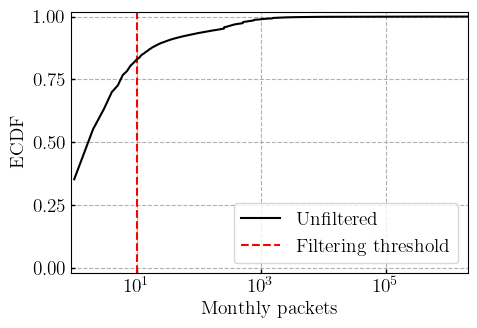

In [11]:
%matplotlib inline
plot = fastplot.plot(None,  None, mode = 'callback', callback = lambda plt: fig2a(plt, cdf),
                     style='latex', cycler=cc, figsize=(5, 3.5), fontsize=14)
plot.show()

### <b>Distinct IPs Seen Over 30 Days</b> <a name="darknetips"></a>  
[Back to Index](#toc_)

After having the filter, we investigate its impact on the full 30 days dataset. Thus we compare the number of distinct IPs seen each day over the observation period between the filtered and unfiltered dataset.

In [12]:
dnet = darknet.copy()
# Count the number of packet per IPs for defining the filter
ips = darknet.value_counts('ip')
# Filter: keep IPs sending at least 10 packets
ips_f = set(ips[ips>=10].index)
# Apply the filter
dnet_f = dnet[dnet.ip.isin(ips_f)]

# Get the number of distinc IPs per day in both the filtered
# and unfiltered case
dnet = get_ip_set_by_day(dnet)
dnet_f = get_ip_set_by_day(dnet_f)
# Make the DataFrame for the fastplot callback
cdf = pd.DataFrame(get_ips_ecdf(dnet))[1].values
cdf_f = pd.DataFrame(get_ips_ecdf(dnet_f))[1].values

<Figure size 640x480 with 0 Axes>

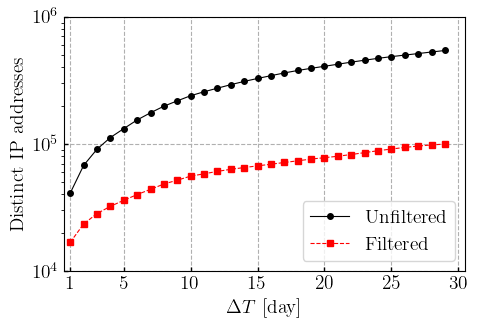

In [13]:
%matplotlib inline
plot = fastplot.plot(None,  None, mode = 'callback', callback = lambda plt: fig2b(plt, cdf, cdf_f),
                     style='latex', cycler=cc, figsize=(5, 3.5), fontsize=14)
plot.show()

___
# <b>Last Day of Traffic</b> <a name="lastday"></a>

[Back to Index](#toc_)

Extract the last day of darknet traffic. we rport in [Appendix 3](A03-darknet-checkpoint.ipynb) the scripts for generating it. Then we apply the filter and provide some statistics on the ground truth. Finally we extract some notable activity patterns.

In [14]:
# Load the filters
with open(f'{DATASETS}/ips.json', 'r') as file:
    filters = json.loads(file.read())

In [17]:
# Load the last day of traffic
darknet_last_day = pd.read_csv(f'{DATASETS}/darknet_d1.csv.gz')
darknet_last_day.head()

,ts,ip,port,proto,pp,class
0,2021-03-31 08:29:08.449076,192.3.136.75,1970,TCP,1970/TCP,unknown
1,2021-03-31 08:29:08.449088,192.3.136.75,1970,TCP,1970/TCP,unknown
2,2021-03-31 08:29:08.451478,192.3.136.75,1970,TCP,1970/TCP,unknown
3,2021-03-31 08:29:08.451491,192.3.136.75,1970,TCP,1970/TCP,unknown
4,2021-03-31 08:29:08.459322,172.245.10.231,3956,TCP,3956/TCP,unknown


Then we apply the filter keeping the IPs sending at least 10 packets over 30 days. Then we extract some statistics about the ground truth

In [18]:
# Filter last day of traffic
last_day  = darknet_last_day[darknet_last_day.ip.isin(filters['d1_f30'])]
# Collect the statistics
stats = [get_last_day_stats(last_day, x) for x in last_day['class'].unique()]
pd.DataFrame(stats, columns=['Source', 'Senders', 'Packets', 
                             'Ports', 'Top-5 Ports (% Traffic)'])\
  .sort_values('Senders', ascending=False)

,Source,Senders,Packets,Ports,Top-5 Ports (% Traffic)
0,unknown,14272,2971687,10715,"445/TCP(9.4%), 5555/TCP(9.4%), 1433/TCP(1.8%),..."
3,mirai,7351,88192,75,"23/TCP(89.6%), 2323/TCP(3.9%), 5555/TCP(1.7%),..."
2,censys,336,233004,11123,"5060/TCP(3.4%), 2000/TCP(2.9%), 443/TCP(0.4%),..."
1,stretchoid,104,57144,91,"22/TCP(3.5%), 443/TCP(3.5%), 9200/TCP(2.7%), 2..."
5,internet-census,103,9396,233,"5060/TCP(10.4%), 161/UDP(9.8%), 2000/TCP(7.7%)..."
4,binaryedge,101,7646,21,"15/TCP(10.0%), 3000/TCP(9.7%), 4222/TCP(6.7%),..."
7,sharashka,50,5436,485,"5986/TCP(0.5%), 2103/TCP(0.5%), 2052/TCP(0.4%)..."
6,ipip,49,17342,41,"5060/TCP(41.5%), -/ICMP(11.0%), 8000/TCP(2.4%)..."
8,shodan,23,13566,363,"2000/TCP(0.7%), 443/TCP(0.7%), 2087/TCP(0.7%),..."
9,engin-umich,10,506,1,53/UDP(100.0%)


### <b>Some Notable GT Activity Patterns</b> <a name="gtpattern"></a> 

[Back to Index](#toc_)

By applying the same technique as before, we extract the activity patterns plot for two ground truth classes: Engin-Umich and Stretchoid.


In [19]:
# Extract the stretchoid traces from the full darknet ones
stretchoid = darknet[darknet['class'] == 'stretchoid']
stretchoid.index = pd.DatetimeIndex(stretchoid.ts)
stretchoid = stretchoid.sort_index()
# Tokenize Stretchoid IPs
ydict = {v: k for k,v in enumerate(stretchoid.ip.unique())}
stretchoid['tkn'] = stretchoid.ip.apply(lambda x: ydict[x])
# Build the activity patterns timeseries
stretchoid = stretchoid[['ip', 'tkn']]
stretchoid.head()

,ip,tkn
ts,,
2021-03-02 21:26:17.800582,192.241.228.149,0
2021-03-02 21:26:18.062857,192.241.228.149,0
2021-03-02 21:26:18.220451,192.241.228.149,0
2021-03-02 21:26:19.341073,192.241.228.149,0
2021-03-02 21:26:20.230202,192.241.228.149,0


<Figure size 640x480 with 0 Axes>

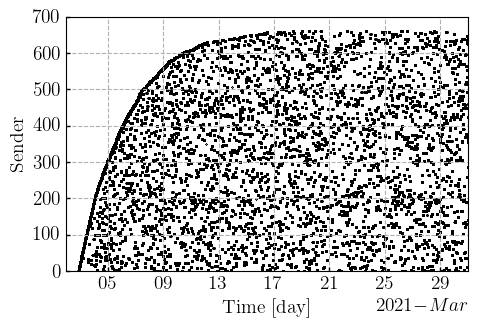

In [20]:
%matplotlib inline
plot = fastplot.plot(None,  None, mode = 'callback', callback = lambda plt: fig8a(plt, stretchoid),
                     style='latex', cycler=cc, figsize=(5, 3.5), fontsize=14)
plot.show()

In [21]:
# Extract the engin-umich traces from the full darknet ones
en_um = darknet[darknet['class'] == 'engin-umich']
en_um.index = pd.DatetimeIndex(en_um.ts)
# Tokenize Stretchoid IPs
ydict = {v: k for k,v in enumerate(en_um.ip.unique())}
en_um['tkn'] = en_um.ip.apply(lambda x: ydict[x])
# Build the activity patterns timeseries
en_um = en_um[['ip', 'tkn']]
en_um.head()

,ip,tkn
ts,,
2021-03-03 00:15:32.045996,141.212.123.185,0
2021-03-03 00:15:39.281339,141.212.123.185,0
2021-03-03 19:05:46.490620,141.212.123.185,0
2021-03-03 19:05:54.828986,141.212.123.185,0
2021-03-03 19:06:11.507999,141.212.123.185,0


<Figure size 640x480 with 0 Axes>

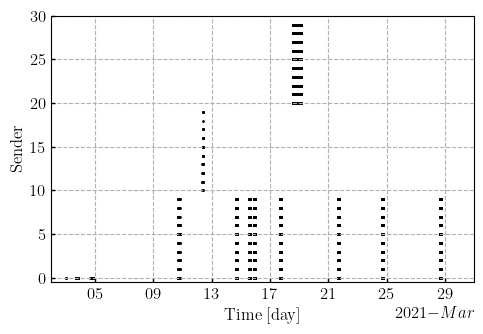

In [22]:
%matplotlib inline
plot = fastplot.plot(None,  None, mode = 'callback', callback = lambda plt: fig8b(plt, en_um),
                     style='latex', cycler=cc, figsize=(5, 3.5), fontsize=12)
plot.show()